# Analysis of advertising sources of mobile game

## 1. Introduction

### Purpose of the work

* To rank channels in terms of cost-effectiveness for acquiring players.

* To provide recommendations for identifying the best acquisition channels and optimizing expenses based on the rankings.

### Work Plan

**1 Introduction**

**2 Data loading and initial inspection**

**3 Data preprocessing**

3.1 Data type checking, data conversion (if necessary)

3.2 Identification of explicit and implicit duplicates

3.3 Checking and filling missing values (if necessary)

**4 Research data analysis:**

*4.1 Financial metrics*

4.1.1 Calculation advertising expenses by channels

4.1.2 The share of attracted users by channels

4.1.3 The cost of customer acquisition by channels


*4.2 Quality of the acquired audience*

4.2.1 The median time to complete a level by channels.

4.2.2 The median number of buildings constructed by channels.

4.2.3 The percentage of players advancing to the second level (project completed) by channels.

**5 Hypothesis testing**

5.1 Test hypothesis "time to complete a level depends on the method of completion: through project implementation, through defeating the first player"

5.2 Test hypothesis "The average number of buildings constructed by players varies depending on the chosen strategy"

**6 Channel rank based on investigated data**

**7 Conclusions**


## **2 Data loading and initial inspection**

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats as st
import numpy as np
from plotly import graph_objects as go

In [2]:
costs, actions, users = (
        pd.read_csv('ad_costs.csv'),
        pd.read_csv('game_actions.csv'),
        pd.read_csv('user_source.csv'))

## **3 Data preprocessing**

### Costs

In [3]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [4]:
costs['day'] = pd.to_datetime(costs['day'])

In [5]:
costs.duplicated().sum()

0

In [6]:
costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

### users

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [8]:
users.duplicated().sum()

0

In [9]:
print( 'In both groups:' , users['user_id'].duplicated().sum())

In both groups: 0


In [10]:
users['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

### actions

In [11]:
action = actions

In [12]:
actions.groupby('event_datetime')

In [13]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [14]:
actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [15]:
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [16]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'], format='%Y.%m.%d %H:%M:%S')

In [17]:
actions['event'].value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [18]:
pd.DataFrame(round(actions.isna().mean()*100)).style.background_gradient('coolwarm')

,0
event_datetime,0.000000
event,0.000000
building_type,6.000000
user_id,0.000000
project_type,99.000000


Check for missing values in the column **building_type**

In [19]:
actions.loc[actions['building_type'].isna(),'event'].value_counts()

finished_stage_1    5817
project             1866
Name: event, dtype: int64

In the column "building_type" 6% of the data is missing. These are the data for players who have already completed the first level or finished the project. We won't fill in such data.

Check for missing values in the column  **project_type**

In [20]:
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [21]:
actions.loc[~actions['project_type'].isna()]

,event_datetime,event,building_type,user_id,project_type
47121,2020-05-08 18:10:25,project,NaN,e3c66498-9d45-4000-9392-f81e6796e7da,satellite_orbital_assembly
57398,2020-05-09 13:49:11,project,NaN,936e7af6-8338-4703-a1df-fc6c3f5b8e34,satellite_orbital_assembly
58797,2020-05-09 16:19:33,project,NaN,a4491c86-c498-4f74-a56e-65c136d0e9a1,satellite_orbital_assembly
61174,2020-05-09 20:29:01,project,NaN,85d9e675-562b-4329-8bbd-14d3b39096be,satellite_orbital_assembly
63770,2020-05-10 00:57:47,project,NaN,1889ca71-3c57-4e61-9ea6-a711971bbf0a,satellite_orbital_assembly
...,...,...,...,...,...
135602,2020-06-02 03:04:42,project,NaN,9d98001c-7e14-40d7-896e-46b3047365fd,satellite_orbital_assembly
135603,2020-06-02 06:21:03,project,NaN,df4a1e13-eba9-4928-a7cf-ee303d6f80f9,satellite_orbital_assembly
135609,2020-06-02 17:17:28,project,NaN,82e46f34-e243-4728-8e20-2e171fc33ea4,satellite_orbital_assembly
135617,2020-06-03 09:46:04,project,NaN,fe032991-71e0-48c5-889f-4c3805ba4c9b,satellite_orbital_assembly


In [22]:
actions.loc[~actions['project_type'].isna(), 'event'].value_counts()

project    1866
Name: event, dtype: int64

In [23]:
actions.loc[actions['project_type'].isna(), 'event'].value_counts()

building            127957
finished_stage_1      5817
Name: event, dtype: int64

These data are related to the strategy, there's no need to fill in the column.

## **4 Research data analysis:**

### 4.1 Financial metrics

#### 4.1.1 Calculation of advertising expenses by channels

In [24]:
cost = costs.groupby('source').agg({'cost':'sum'}).sort_values(by='cost', ascending = False) 
cost['cost%'] = round(cost['cost']/cost['cost'].sum()*100)
cost

,cost,cost%
source,,
yandex_direct,2233.111449,29.0
instagram_new_adverts,2161.441691,28.0
facebook_ads,2140.904643,28.0
youtube_channel_reklama,1068.119204,14.0


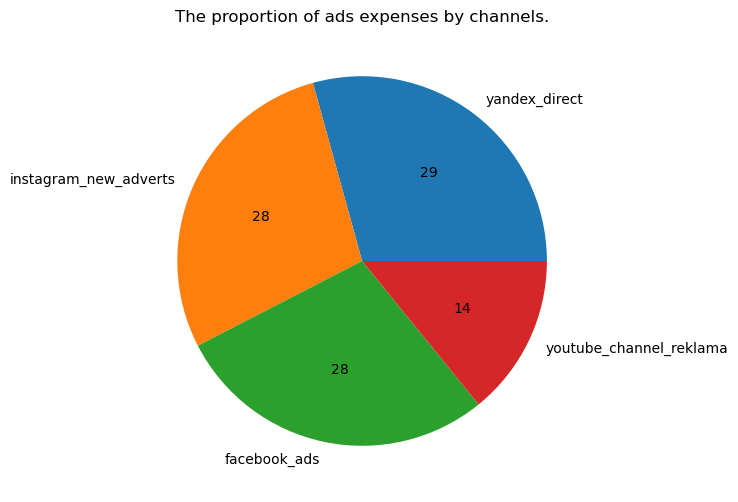

In [25]:
cost.plot(y='cost%', 
          kind='pie',
          figsize=(6,6),
          autopct='%.f',
          legend = False,
          title= 'The proportion of ads expenses by channels.',
          label='');

**Conclusion**

Approximately the same costs are accounted for Yandex, Instagram and Facebook 28-29%. The lowest funding among all is allocated to YouTube (14%).

####  4.1.2 The share of attracted users by channels.

In [26]:
user = users.groupby('source').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False) 
user['user_id%'] = round(user['user_id']/user['user_id'].sum()*100)
user

,user_id,user_id%
source,,
yandex_direct,4817,35.0
instagram_new_adverts,3347,25.0
facebook_ads,2726,20.0
youtube_channel_reklama,2686,20.0


**Conclusion**

The largest share of users came from Yandex, accounting for 35%, slightly less from Instagram at 25%, while Facebook and YouTube each contribute 20% of all incoming users.

#### 4.1.3 The cost of customer acquisition by channels

In [27]:
financial = cost.merge(user, on='source').reset_index()
financial['cost_per_1'] = financial['cost']/financial['user_id']
financial['cost_per_1%'] = (round(financial['cost_per_1']/financial['cost_per_1'].sum()*100))
financial

,source,cost,cost%,user_id,user_id%,cost_per_1,cost_per_1%
0,yandex_direct,2233.111449,29.0,4817,35.0,0.463590,20.0
1,instagram_new_adverts,2161.441691,28.0,3347,25.0,0.645785,28.0
2,facebook_ads,2140.904643,28.0,2726,20.0,0.785365,34.0
3,youtube_channel_reklama,1068.119204,14.0,2686,20.0,0.397662,17.0


In [28]:
financial[['source','cost_per_1','cost_per_1%']].sort_values(by='cost_per_1')

,source,cost_per_1,cost_per_1%
3,youtube_channel_reklama,0.397662,17.0
0,yandex_direct,0.463590,20.0
1,instagram_new_adverts,0.645785,28.0
2,facebook_ads,0.785365,34.0


**Conclusion** 


The most cost-effective advertising is for customers coming from YouTube, with a cost of 0.397662 units (17% of the share of all other sources). Slightly more expensive are customers from Yandex Direct, with a cost of 0.463590 per acquisition or 20%. Instagram follows with 0.645785 units or 28%, and the most expensive customers come from Facebook with a cost of 0.785365 or 34%

### 4.1 Conclusion


Despite the fact that customers from YouTube are the least expensive for the company (0.397662 units), the Yandex Direct channel proves to be the most optimal in terms of the cost and number of acquired customers.

Although advertising on Yandex is slightly more expensive (0.463590 units), this channel attracted the maximum number of players (4817) compared to other channels.

However, it is essential to investigate the quality of this acquired audience.

### 4.2 Quality of the acquired audience

####  4.2.1 The median time to complete a level by channels

In [29]:
actions = actions.merge(users, on='user_id')

In [30]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime']).dt.day

In [31]:
mean_time = actions.groupby(['source','user_id']).agg(max=('event_datetime','max'), min=('event_datetime','min')).reset_index()
mean_time['days_till_finish'] = mean_time['max'] - mean_time['min']
mean_time.head()

,source,user_id,max,min,days_till_finish
0,facebook_ads,0001f83c-c6ac-4621-b7f0-8a28b283ac30,20,6,14
1,facebook_ads,002f508f-67b6-479f-814b-b05f00d4e995,22,5,17
2,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,16,4,12
3,facebook_ads,00440efd-aa50-4b4b-aae8-ffcd1782729d,9,4,5
4,facebook_ads,00965328-5e54-453f-b11b-52f8ae9ae80b,18,7,11


In [32]:
median_days = mean_time.groupby('source').agg({'days_till_finish':'median'})
median_days

,days_till_finish
source,
facebook_ads,11.0
instagram_new_adverts,11.0
yandex_direct,10.0
youtube_channel_reklama,10.0


**Conclusion** 

On average, all players complete the level within 10-11 days. Users coming from Yandex and YouTube in Canada complete the game in 10 days, while those from Instagram and Facebook take 11 days.

#### 4.2.2 The median number of buildings constructed by channels

In [33]:
median_buildings = (
    actions.groupby(['source','user_id'])
    .agg(count_built=('building_type','count'))).groupby('source').agg({'count_built':'median'})

median_buildings

,count_built
source,
facebook_ads,10.0
instagram_new_adverts,10.0
yandex_direct,10.0
youtube_channel_reklama,10.0


**Conclusion** 


All users build the same number of buildings regardless of the channel they come from.

#### 4.2.3 The percentage of players advancing to the second level (project completed) by channels.

In [34]:
next_lavel = (
    actions.loc[actions['event'] == 'project']).groupby('source').agg(finished_1_lavel=('event','count'),
                                                                     ).sort_values(by='finished_1_lavel', ascending = False
                                                                                  ).reset_index()

to_next_lavel = next_lavel.merge(user, on='source')
to_next_lavel = to_next_lavel[['source', 'finished_1_lavel', 'user_id']]
to_next_lavel['finished_1_lavel%'] = round(to_next_lavel['finished_1_lavel']/ to_next_lavel['user_id']*100)
to_next_lavel

,source,finished_1_lavel,user_id,finished_1_lavel%
0,yandex_direct,620,4817,13.0
1,instagram_new_adverts,476,3347,14.0
2,facebook_ads,391,2726,14.0
3,youtube_channel_reklama,379,2686,14.0


**Conclusion** 

Players from the Yandex channel have a slightly lower completion rate for the first level, standing at 13%, in contrast to 14% for Facebook, Instagram, and YouTube.

### 4.2 Conclusion



On average, all players complete the level within 10-11 days. Users coming from Yandex and YouTube in Canada complete the game in 10 days, while those from Instagram and Facebook take 11 days.

All users build the same number of buildings regardless of the channel they come from.

Players from the Yandex channel have a slightly lower completion rate for the first level, standing at 13%, in contrast to 14% for Facebook, Instagram, and YouTube.

### 5 Hypothesis testing

####  5.1 Test hypothesis "time to complete a level depends on the method of completion: through project implementation, through defeating the first player"

To test the hypothesis, we need to categorize into groups based on the completion method:

* PVE (Player vs. Environment) - includes events with 'finish_stage_1' and project_type 'satellite_orbital_assembly'.

* PVP (Player vs. Player) - includes events with 'finish_stage_1' and NO station.

##### PVE

In [35]:
actions.loc[~actions['project_type'].isna()]

,event_datetime,event,building_type,user_id,project_type,source
17,13,project,NaN,c07b1c10-f477-44dc-81dc-ec82254b1347,satellite_orbital_assembly,facebook_ads
97,18,project,NaN,65a92713-5969-48b1-8945-bfefa5063887,satellite_orbital_assembly,yandex_direct
110,18,project,NaN,fa352362-d258-472c-b295-2796ccc39fa3,satellite_orbital_assembly,youtube_channel_reklama
149,14,project,NaN,7b3b6554-7949-4065-9808-d6c79bdc2f58,satellite_orbital_assembly,instagram_new_adverts
219,14,project,NaN,b374304d-2f74-4cc1-a4e2-500da44a06c7,satellite_orbital_assembly,facebook_ads
...,...,...,...,...,...,...
134769,21,project,NaN,73e509b2-24eb-43eb-af8d-33d422b66c4b,satellite_orbital_assembly,youtube_channel_reklama
135067,25,project,NaN,ebc83c73-7efc-4e57-b206-6d2cb9388b8a,satellite_orbital_assembly,yandex_direct
135365,22,project,NaN,92c1bdec-8449-4769-bf15-203c8e5830cc,satellite_orbital_assembly,facebook_ads
135534,26,project,NaN,825e727b-7847-4c5f-a26c-3ee0f18d8177,satellite_orbital_assembly,youtube_channel_reklama


In [36]:
unique_id_pve = actions.loc[~actions['project_type'].isna(), 'user_id'].unique()
unique_id_pve

array(['c07b1c10-f477-44dc-81dc-ec82254b1347',
       '65a92713-5969-48b1-8945-bfefa5063887',
       'fa352362-d258-472c-b295-2796ccc39fa3', ...,
       '92c1bdec-8449-4769-bf15-203c8e5830cc',
       '825e727b-7847-4c5f-a26c-3ee0f18d8177',
       '637a8d39-3872-4549-80cc-bebee6c88056'], dtype=object)

In [37]:
pve = actions.loc[actions['user_id'].isin(unique_id_pve)]
pve

,event_datetime,event,building_type,user_id,project_type,source
7,4,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
8,6,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
9,7,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
10,7,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
11,7,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
...,...,...,...,...,...,...
135584,28,building,spaceport,637a8d39-3872-4549-80cc-bebee6c88056,NaN,yandex_direct
135585,28,building,research_center,637a8d39-3872-4549-80cc-bebee6c88056,NaN,yandex_direct
135586,30,building,research_center,637a8d39-3872-4549-80cc-bebee6c88056,NaN,yandex_direct
135587,1,project,NaN,637a8d39-3872-4549-80cc-bebee6c88056,satellite_orbital_assembly,yandex_direct


##### PVP

In [38]:
unique_id_pvp = (actions.loc[actions['event'] == 'finished_stage_1']).loc[~
    (actions.loc[actions['event'] == 'finished_stage_1'])['user_id']
    .isin(unique_id_pve), 'user_id'
].unique()

In [39]:
pvp = actions.loc[actions['user_id'].isin(unique_id_pvp)]
pvp

,event_datetime,event,building_type,user_id,project_type,source
20,4,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
21,7,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
22,7,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
23,7,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
24,8,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
...,...,...,...,...,...,...
135617,17,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,youtube_channel_reklama
135618,23,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,youtube_channel_reklama
135619,26,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,youtube_channel_reklama
135620,30,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,youtube_channel_reklama


#####   Verification by strategies

In [40]:
print( 'The total number of users who clicked the button: ' ,
      actions.loc[actions['event'] == 'finished_stage_1', 'event'].value_counts())

The total number of users who clicked the button:  finished_stage_1    5817
Name: event, dtype: int64


In [41]:
print( 'The total number of users following the PVE strategy:' , 
      pve.loc[pve['event'] == 'finished_stage_1', 'event'].value_counts())

The total number of users following the PVE strategy: finished_stage_1    1866
Name: event, dtype: int64


In [42]:
print( 'The total number of users following the PVP strategy:' ,
      pvp.loc[pvp['event'] == 'finished_stage_1', 'event'].value_counts())

The total number of users following the PVP strategy: finished_stage_1    3951
Name: event, dtype: int64


In [43]:
(pve.loc[pve['event'] == 'finished_stage_1', 'event'].value_counts())+(
    pvp.loc[pvp['event'] == 'finished_stage_1', 'event'].value_counts())

finished_stage_1    5817
Name: event, dtype: int64

##### Hypothesis testing

In [44]:
pvp_time = pvp.groupby('user_id').agg(max=('event_datetime','max'), min=('event_datetime','min')).reset_index()
pvp_time['count'] = pvp_time['max'] - pvp_time['min']
pvp_time

,user_id,max,min,count
0,001d39dc-366c-4021-9604-6a3b9ff01e25,12,5,7
1,003ee7e8-6356-4286-a715-62f22a18d2a1,17,5,12
2,004074f8-251a-4776-922c-8348dca1a2f6,16,4,12
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,15,4,11
4,0056c007-c082-43cc-bdef-afc49bca4cb9,16,10,6
...,...,...,...,...
3946,ffc6f4fa-3476-47af-85cb-e2ee0551110a,15,4,11
3947,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,19,6,13
3948,ffe810f4-1a1f-464b-924d-6f120b0cb8df,18,4,14
3949,ffef4fed-164c-40e1-bde1-3980f76d0fb5,11,4,7


In [45]:
pve_time = pve.groupby('user_id').agg(max=('event_datetime','max'), min=('event_datetime','min')).reset_index()
pve_time['count'] = pve_time['max'] - pve_time['min']
pve_a = pve_time
pve_time

,user_id,max,min,count
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,16,4,12
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,24,8,16
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,27,7,20
3,00de2809-403e-4476-a2f7-ca1b11700190,18,4,14
4,00e83261-5fd4-4939-9616-802b5a0202c6,20,5,15
...,...,...,...,...
1861,ff50f63a-c4b3-494e-8bf9-3f19dbfc513e,23,4,19
1862,ff60fcd1-4329-494e-b82d-461fbdf5b5eb,13,5,8
1863,ff83bdd8-f49a-49fd-8aad-9fa1fb30d516,18,4,14
1864,ff841992-d93b-462e-bc6e-18c24a514f36,16,5,11


To test the hypothesis, we will use the "Comparison of Two Independent Samples" method or ttest_ind.

Hypotheses:

* H0: The mean completion time does not differ depending on the method of completing the PVE and PVP strategies.

* Alternative hypothesis: The mean completion time differs.

Set the significance level alpha at 5%

In [46]:
alpha = 0.05

results = st.ttest_ind( (pve_time['count']) , 
                       (pvp_time['count']),
                       equal_var = False)

print(results.pvalue)
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

7.382571911126114e-105
Reject the null hypothesis


In [47]:
print('PVE',  pve_time['count'].median())
print('PVP',  pvp_time['count'].median())

PVE 13.0
PVP 11.0


**Conclusion**

According to the results of the statistical test, we reject the null hypothesis and conclude that the completion time of the level differs significantly depending on the method of completing the PVE and PVP strategies. Players following the PVP strategy complete the game earlier, within 11 days, compared to players in the PVE strategy who take 13 days.

####  5.2 Test hypothesis "The average number of buildings constructed by players varies depending on the chosen strategy"

To test this hypothesis with "Comparison of Two Independent Samples" method or ttest_ind.

Hypotheses:

H0: The average number of buildings constructed by players varies depending on the chosen strategy.

Alternative hypothesis: The average number differs.

Set the significance level alpha at 5%.

In [48]:
pvp_а = pvp.groupby('user_id').agg(count=('building_type','count')).reset_index()

In [49]:
results = st.ttest_ind(pvp_а['count'],
                       pve_a['count'],
                       equal_var = False)

print(results.pvalue)
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

9.150438114161319e-304
Reject the null hypothesis


**Conclusion**

According to the results of the statistical test, we reject the null hypothesis and consider that the average number of buildings statistically differs depending on the method of completing the PVE and PVP strategies.

## 6 Channel rank

In [50]:
table = financial.merge(median_days, on='source')
table = table.merge(to_next_lavel, on='source')
table = table.merge(median_buildings, on='source')
table_imp = table[['source', 'cost%', 'user_id%', 'cost_per_1%', 'days_till_finish', 'finished_1_lavel%', 'count_built']]
table_imp.sort_values(by='cost_per_1%')

,source,cost%,user_id%,cost_per_1%,days_till_finish,finished_1_lavel%,count_built
3,youtube_channel_reklama,14.0,20.0,17.0,10.0,14.0,10.0
0,yandex_direct,29.0,35.0,20.0,10.0,13.0,10.0
1,instagram_new_adverts,28.0,25.0,28.0,11.0,14.0,10.0
2,facebook_ads,28.0,20.0,34.0,11.0,14.0,10.0


## Conclusion

**Channel ranking:**

The most cost-effective channel in terms of cost-effectiveness is YouTube, as the advertising expenses are the lowest among all channels (0.397662 units or 17% of the share of all other sources), and the players are the most active. About 14% of users reach the finish line (vs. 13% for Yandex), and they complete the level in 10 days.

Next is Yandex.Direct. Advertising on Yandex is slightly more expensive than on YouTube (0.463590 units or 20% in the share), and users complete the first level slightly less efficiently. However, those who do complete it, do so in 10 days (vs. Instagram and Facebook).

Advertising on Instagram is more expensive at 0.645785 units or 28%. Players are less active and take longer to complete the level - an average of 11 days. However, compared to Yandex, a higher percentage reaches the end of level 1 (14% vs. 13% for Yandex).

The least effective channel is Facebook. It attracts as many users as YouTube, but the advertising cost per user is twice as high (0.785365 or 34%). The same percentage of users as YouTube completes the first level (14%), but they take longer - 11 days.


**Game Strategies**


The game has two strategies:

* PVE - Players build an orbital station and then complete the project.
* PVP - Players do not build a station; they engage in battles and also complete the project.

Completion Time:

According to the results of the statistical test, we conclude that the completion time statistically differs depending on the method of completing the PVE and PVP strategies, and players following the PVP strategy finish the game earlier than PVE players. Additionally, the mean number of buildings statistically differs between strategies.

**Recommendations:**

Recommended significantly increase funding for the YouTube channel, because the most high-quality users come from there and with a low user acquisition. Depending on the company's goals, pay attention on maintaining or reducing funding for the Yandex channel and possibly eliminating or significantly reducing funding for Instagram and Facebook.

Depending on the company's goals, also pay attention on game strategies: PVP players finish the project faster (11 days vs. 13 days for PVE) but also construct fewer buildings (10 buildings vs. 12 for PVE).